# Домашнее задание. Классификация изображений

Сегодня вам предстоить помочь телекомпании FOX в обработке их контента. Как вы знаете, сериал "Симпсоны" идет на телеэкранах более 25 лет, и за это время скопилось очень много видеоматериала. Персоонажи менялись вместе с изменяющимися графическими технологиями, и Гомер Симпсон-2018 не очень похож на Гомера Симпсона-1989. В этом задании вам необходимо классифицировать персонажей, проживающих в Спрингфилде. Думаю, нет смысла представлять каждого из них в отдельности.



### Установка зависимостей

In [29]:
import torch
import copy
import numpy as np

import gc
import pickle
from skimage import io

from tqdm.notebook import tqdm
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [5]:
import PIL
print(PIL.__version__)

10.2.0


In [6]:
!nvidia-smi
import torch
torch.cuda.is_available()

Mon Apr  8 23:26:07 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 551.61                 Driver Version: 551.61         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 2060 ...  WDDM  |   00000000:09:00.0  On |                  N/A |
| 31%   39C    P8             11W /  184W |    1693MiB /   8192MiB |      4%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

True

В нашем тесте будет 990 картинок, для которых вам будет необходимо предсказать класс.

In [7]:
# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
device = torch.device("cuda")

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation.

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample)

In [8]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [70]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [9]:
#определим директории с тренировочными и тестовыми файлами
TRAIN_DIR = Path('./train/')
TEST_DIR = Path('./testset')

In [10]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [11]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [12]:
val_dataset = SimpsonsDataset(val_files, mode='val')

Давайте посмотрим на наших героев внутри датасета.

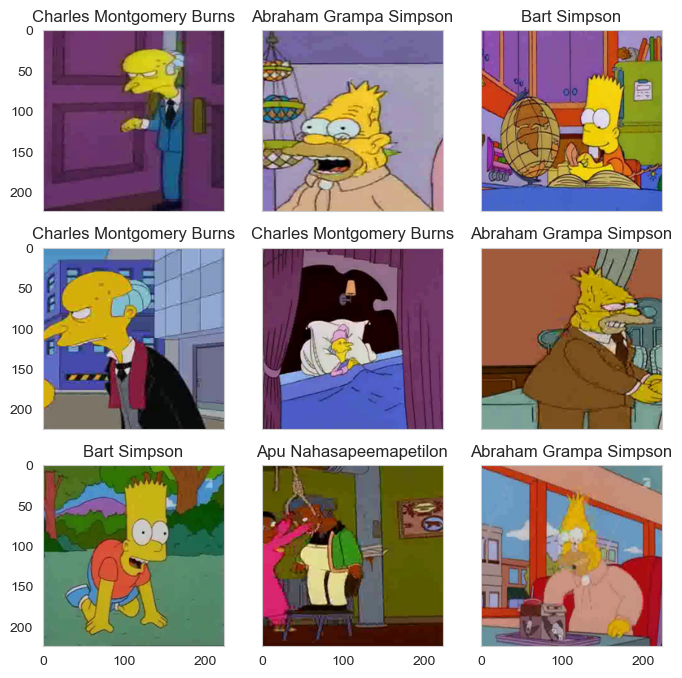

In [14]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

Можете добавить ваши любимые сцены и классифицировать их. (веселые результаты можно кидать в чат)

### Построение нейросети

Запустить данную сеть будет вашим мини-заданием на первую неделю, чтобы было проще участвовать в соревновании.

Данная архитектура будет очень простой и нужна для того, чтобы установить базовое понимание и получить простенький сабмит на Kaggle

<!-- Здесь вам предлагается дописать сверточную сеть глубины 4/5.  -->

*Описание слоев*:



1. размерность входа: 3x224x224
2.размерности после слоя:  8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. выход: 96x5x5


In [15]:
# Очень простая сеть
class SimpleCnn(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.out = nn.Linear(96 * 5 * 5, n_classes)


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [16]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [17]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
        
    val_loss = running_loss / processed_data
    val_acc = running_corrects.double() / processed_data
    return val_loss, val_acc

In [18]:
def train(train_dataset, val_dataset, model, opt, epochs, batch_size, patience=5):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=patience)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            lr_scheduler.step(val_loss)

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    return history

In [26]:
def train_model(model, batch_size, criterion, optimizer, lr_scheduler, epochs=15):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    dataloaders = {'train': train_loader, 'val': val_loader}

    losses = {'train': [], 'val': []}
    accuracies = {'train': [], 'val': []}

    running_accuracy = 0
    running_loss = 0

    best_model_wts = model.state_dict()
    best_accuracy = 0

    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
        val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar:

        for epoch in range(epochs):
            for data_mode in DATA_MODES[:2]:
                if data_mode == 'train':
                    model.train()
                else:
                    model.eval()

                data_size = 0
                running_accuracy = 0
                running_loss = 0

                for X, y in tqdm(dataloaders[data_mode]):
                    # uniform device
                    X = X.to(device)
                    y = y.to(device)

                    optimizer.zero_grad()

                    if data_mode == 'train':
                        logits = model(X)

                        loss = criterion(logits, y)
                        loss.backward()

                        optimizer.step()

                        preds = torch.argmax(logits, dim=1)

                        running_accuracy += torch.sum((preds == y.data)).item()
                        running_loss += loss.item() * X.size(0)
                        data_size += X.size(0)


                    else:  # data_mode == 'val'
                        with torch.no_grad():
                            logits = model(X)

                            loss = criterion(logits, y)

                            preds = torch.argmax(logits, 1)

                            running_accuracy += torch.sum((preds == y.data)).item()
                            running_loss += loss.item() * X.size(0)
                            data_size += X.size(0)

                epoch_accuracy = running_accuracy / data_size
                accuracies[data_mode].append(epoch_accuracy)

                epoch_loss = running_loss / data_size
                losses[data_mode].append(epoch_loss)
                
            if data_mode == 'train':
                lr_scheduler.step()

            # сохраняем лучшую модель 
            if data_mode == 'val' and epoch_accuracy > best_accuracy:
                best_accuracy = epoch_accuracy
                print('Saving best model...')
                best_model_wts = copy.deepcopy(model.state_dict())

            pbar.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=losses['train'][-1], \
                                           v_loss=losses['val'][-1], t_acc=accuracies['train'][-1], v_acc=accuracies['val'][-1]))


    model.load_state_dict(best_model_wts)
    return model, losses, accuracies

In [60]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(device)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

Запустим обучение сети.

In [15]:
n_classes = len(np.unique(train_val_labels))
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')

train_dataset = SimpsonsDataset(train_files, mode='train')

### Ну и что теперь со всем этим делать?

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

Хорошо бы понять, как сделать сабмит.
У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит softmax, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному классу. Давайте воспользуемся этим.

In [62]:
def predict_one_sample(model, inputs, device=device):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [63]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(best_model, ex_img.unsqueeze(0))

In [64]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(best_model, imgs)

In [65]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [66]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе --- f1-score. Вычислим целевую метрику на валидационной выборке.

In [67]:
from sklearn.metrics import f1_score
f1 = f1_score(actual_labels, y_pred, average='micro')

print("F1-оценка:", f1)


F1-оценка: 0.9


Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

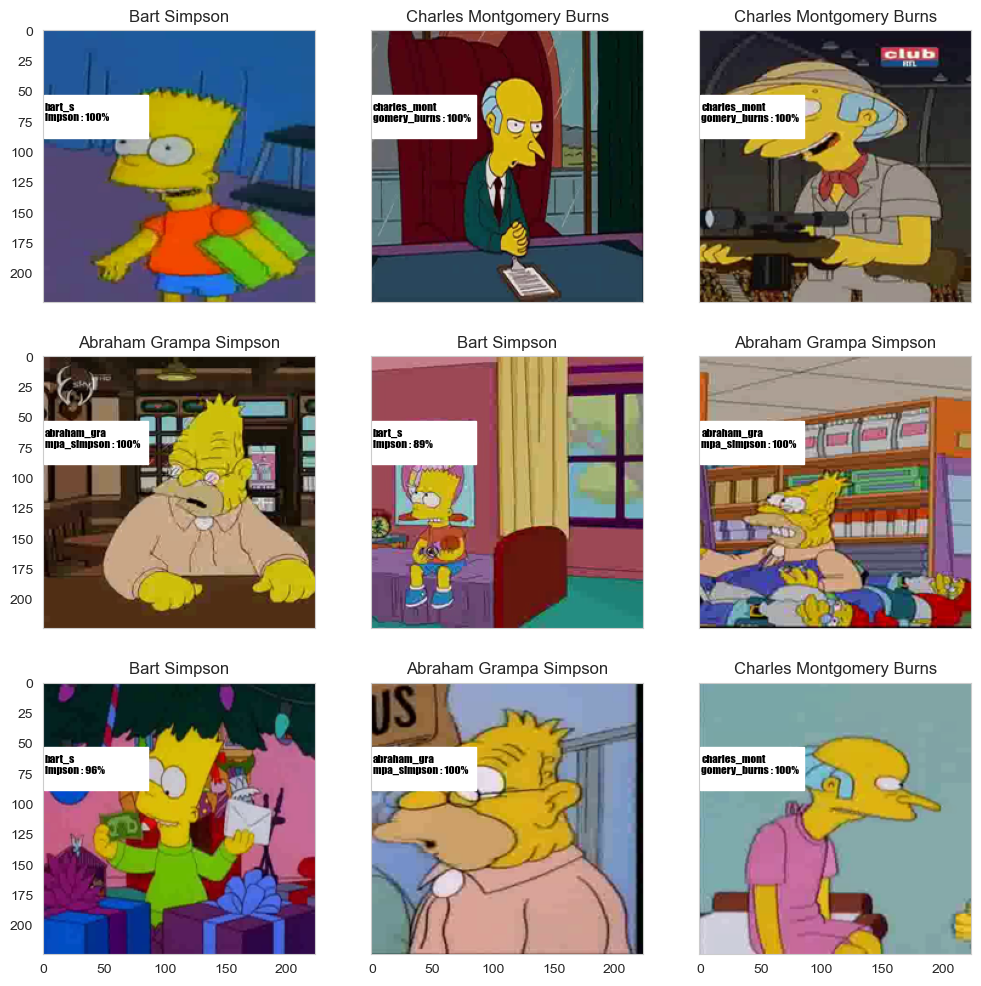

In [71]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))



    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

    actual_text = "Actual : {}".format(img_label)

    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(best_model, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)

    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)

    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

Попробуйте найти те классы, которые сеть не смогла расспознать. Изучите данную проблему, это понадобится в дальнейшем.

### Submit на Kaggle

![alt text](https://i.redd.it/nuaphfioz0211.jpg)

In [88]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(best_model, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [ ]:
! ls

In [89]:
import pandas as pd
my_submit = pd.read_csv("sample_submission.csv")
my_submit.head()

,Id,Expected
0,img0.jpg,bart_simpson
1,img1.jpg,bart_simpson
2,img2.jpg,bart_simpson
3,img3.jpg,bart_simpson
4,img4.jpg,bart_simpson


In [90]:
for i in range(len(test_files)):
    my_submit.Expected[int(test_files[i].name[3:-4])] = preds[i]
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img2.jpg,edna_krabappel
3,img3.jpg,nelson_muntz
4,img4.jpg,lisa_simpson


In [91]:
my_submit.to_csv('simple_cnn_baseline.csv', index=False)

## Приключение?

А теперь самое интересное, мы сделали простенькую сверточную сеть и смогли отправить сабмит, но получившийся скор нас явно не устраивает. Надо с этим что-то сделать.

Несколько срочныйх улучшейни для нашей сети, которые наверняка пришли Вам в голову:


*   Учим дольше и изменяем гиперпараметры сети
*  learning rate, batch size, нормализация картинки и вот это всё
*   Кто же так строит нейронные сети? А где пулинги и батч нормы? Надо добавлять
*  Ну разве Адам наше все? [adamW](https://www.fast.ai/2018/07/02/adam-weight-decay/) для практика, [статейка для любителей](https://openreview.net/pdf?id=ryQu7f-RZ) (очень хороший анализ), [наши ](https://github.com/MichaelKonobeev/adashift/) эксперименты для заинтересованных.

* Ну разве это deep learning? Вот ResNet и Inception, которые можно зафайнтьюнить под наши данные, вот это я понимаю (можно и обучить в колабе, а можно и [готовые](https://github.com/Cadene/pretrained-models.pytorch) скачать).

* Данных не очень много, можно их аугументировать и  доучититься на новом датасете ( который уже будет состоять из, как  пример аугументации, перевернутых изображений)

* Стоит подумать об ансамблях


Надеюсь, что у Вас получится!

![alt text](https://pbs.twimg.com/profile_images/798904974986113024/adcQiVdV.jpg)


In [50]:
from torchvision import models

Ускоряем обучение и чистим память

In [51]:
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =  True
torch.backends.cudnn.deterministic = False
gc.collect()

3721

Берем предобученный resnet50 на ImageNet. Хотим использовать Transfer Learning.

In [52]:
my_model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)

my_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Выключаем обучение у conv слоев, обучаем замененный классификатор отдельно, чтобы его плохие веса не сломали предыдущие conv слои.

In [53]:
for param in my_model.parameters():
    param.requires_grad = False
    
my_model.fc = nn.Linear(2048, n_classes)
my_model = my_model.to(device)

Используем AdamW, жертвуя скоростью, но производя честное вычисление градиента.

In [56]:
opt = torch.optim.AdamW(
    [
        {'params': my_model.layer4.parameters(), 'lr': 1e-4},
        {'params': my_model.fc.parameters(), 'lr': 1e-3}
    ], lr=1e-6,
)
criterion = nn.CrossEntropyLoss()
exp_lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=3, factor=0.1)

Немного обучаем, чтобы настроить классификатор.

In [55]:
best_model, losses, accuracies = train_model(model=my_model, batch_size=64, criterion=criterion, optimizer=opt, lr_scheduler=exp_lr_scheduler, epochs=2)

epoch:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/246 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

Saving best model...

Epoch 001 train_loss: 2.1821         val_loss 1.5631 train_acc 0.5074 val_acc 0.6867


  0%|          | 0/246 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

Saving best model...

Epoch 002 train_loss: 1.2650         val_loss 1.1781 train_acc 0.7358 val_acc 0.7415


Включаем обучение последнего conv слоя.

In [57]:
for param in my_model.layer4.parameters():
    param.requires_grad = True

Обучаем полноценно.

In [58]:
best_model, losses, accuracies = train_model(model=my_model, batch_size=64, criterion=criterion, optimizer=opt, lr_scheduler=exp_lr_scheduler, epochs=10)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/246 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

Saving best model...

Epoch 001 train_loss: 0.3962         val_loss 0.3060 train_acc 0.8980 val_acc 0.9249


  0%|          | 0/246 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

Saving best model...

Epoch 002 train_loss: 0.0408         val_loss 0.2809 train_acc 0.9922 val_acc 0.9295


  0%|          | 0/246 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

Saving best model...

Epoch 003 train_loss: 0.0068         val_loss 0.2796 train_acc 0.9996 val_acc 0.9339


  0%|          | 0/246 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

Saving best model...

Epoch 004 train_loss: 0.0029         val_loss 0.2789 train_acc 0.9999 val_acc 0.9373


  0%|          | 0/246 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]


Epoch 005 train_loss: 0.0017         val_loss 0.2922 train_acc 0.9999 val_acc 0.9350


  0%|          | 0/246 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]


Epoch 006 train_loss: 0.0013         val_loss 0.2973 train_acc 0.9999 val_acc 0.9343


  0%|          | 0/246 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]


Epoch 007 train_loss: 0.0016         val_loss 0.3029 train_acc 0.9997 val_acc 0.9368


  0%|          | 0/246 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]


Epoch 008 train_loss: 0.0051         val_loss 0.2993 train_acc 0.9991 val_acc 0.9366


  0%|          | 0/246 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

Saving best model...

Epoch 009 train_loss: 0.0029         val_loss 0.3037 train_acc 0.9996 val_acc 0.9391


  0%|          | 0/246 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]


Epoch 010 train_loss: 0.0043         val_loss 0.3340 train_acc 0.9992 val_acc 0.9329


Название команды: Илья_Яковлев_203535254

F1-score: 0.96918 (Я устал мучить это задание, так что не буде добивать 0.97)

Я устал мучить это задание, так что не буду добивать 0.97. Надеюсь, мой результат можно приравнять к нему.

Спасибо за проверку :)